In [1]:
import timm
import numpy as np
import torch.nn as nn
import torch.optim as optim
from transformers import ViTImageProcessor, ViTModel
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset, Features, Array3D, ClassLabel, load_dataset
from torch.utils.data import DataLoader
import torch
from collections import Counter

In [2]:
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:1000]'])

In [3]:
train_counts = Counter(train_ds['label'])
test_counts = Counter(test_ds['label'])
train_counts, test_counts

(Counter({2: 525,
          4: 525,
          5: 520,
          8: 520,
          6: 509,
          9: 490,
          7: 482,
          0: 479,
          1: 479,
          3: 471}),
 Counter({6: 112,
          9: 109,
          8: 106,
          3: 103,
          0: 103,
          7: 102,
          2: 100,
          4: 90,
          1: 89,
          5: 86}))

In [4]:
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
def preprocess_images(examples):
    inputs = feature_extractor(images=examples['img'], return_tensors='np')
    examples['pixel_values'] = inputs['pixel_values']
    return examples

In [5]:
features = Features({
    'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']),
    'img': Array3D(dtype="int64", shape=(3,32,32)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})
preprocessed_train_ds = train_ds.map(
    preprocess_images,
    batched=True,
    remove_columns=["img"]
)

preprocessed_test_ds = test_ds.map(
    preprocess_images,
    batched=True,
    remove_columns=["img"]
)

In [6]:
preprocessed_train_ds.set_format(
    type="torch",
    columns=["pixel_values", "label"]
)

preprocessed_test_ds.set_format(
    type="torch",
    columns=["pixel_values", "label"]
)

In [7]:
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
for param in vit_model.parameters():
      param.requires_grad = False

In [8]:
num_labels=10
class ImageClassificationModel(nn.Module):
    def __init__(self, num_labels=10):
        super(ImageClassificationModel, self).__init__()
        self.vit = vit_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)
        return logits

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
model = ImageClassificationModel()
model.to(device)

ImageClassificationModel(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermedi

In [13]:
labels_list = [int(l) for l in preprocessed_train_ds['label']]
classes = np.unique(labels_list)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=labels_list
)

weights = torch.tensor(class_weights, dtype=torch.float).to(device)
weights

tensor([1.0438, 1.0438, 0.9524, 1.0616, 0.9524, 0.9615, 0.9823, 1.0373, 0.9615,
        1.0204], device='cuda:0')

In [14]:
cross_entropy = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.0001,
)

In [15]:
train_batch_size = 10
eval_batch_size = 10
train_loader = torch.utils.data.DataLoader(preprocessed_train_ds, batch_size=train_batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(preprocessed_test_ds, batch_size=eval_batch_size, num_workers=0)

In [16]:
def train():
    model.train()
    total_loss = 0
    for step,batch in enumerate(train_loader):
        pix = batch["pixel_values"].to(device)
        lbl = batch["label"].to(device)
        preds = model(pix)
        loss = cross_entropy(preds, lbl)
        total_loss = total_loss + loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()  
    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [17]:
def test():
    total_loss = 0
    model.eval()
    for step, batch in enumerate(test_loader):
        pix = batch["pixel_values"].to(device)
        lbl = batch["label"].to(device)
        preds = model(pix)
        loss = cross_entropy(preds, lbl)
        total_loss += loss.item()
    
    return total_loss / len(test_loader)

In [18]:
epochs = 10
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    val_loss = test()
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'\n Training Loss: {train_loss:.3f}')
    print(f'\n Test Loss: {val_loss:.3f}')


 Epoch 1 / 10

 Training Loss: 1.785

 Test Loss: 1.327

 Epoch 2 / 10

 Training Loss: 0.999

 Test Loss: 0.756

 Epoch 3 / 10

 Training Loss: 0.596

 Test Loss: 0.506

 Epoch 4 / 10

 Training Loss: 0.419

 Test Loss: 0.390

 Epoch 5 / 10

 Training Loss: 0.328

 Test Loss: 0.323

 Epoch 6 / 10

 Training Loss: 0.273

 Test Loss: 0.281

 Epoch 7 / 10

 Training Loss: 0.237

 Test Loss: 0.253

 Epoch 8 / 10

 Training Loss: 0.211

 Test Loss: 0.232

 Epoch 9 / 10

 Training Loss: 0.191

 Test Loss: 0.217

 Epoch 10 / 10

 Training Loss: 0.176

 Test Loss: 0.205


In [19]:
torch.save(model.state_dict(), 'trained_model')

In [20]:
def predict():
    model.eval()
    y_pred = []
    y_true = []
    for step, batch in enumerate(test_loader):
        pix = batch["pixel_values"].to(device)
        lbl = batch["label"].to(device)
        outputs = model(pix)
        outputs = torch.argmax(outputs, axis=1)
        # print(outputs)
        y_pred.extend(outputs.cpu().detach().numpy())
        y_true.extend(lbl.cpu().detach().numpy()) 
    return y_pred, y_true
    
y_pred, y_true = predict()

def predict_train():
    model.eval()
    y_pred = []
    y_true = []
    for step, batch in enumerate(train_loader):
        pix = batch["pixel_values"].to(device)
        lbl = batch["label"].to(device)
        outputs = model(pix)
        outputs = torch.argmax(outputs, axis=1)
        # print(outputs)
        y_pred.extend(outputs.cpu().detach().numpy())
        y_true.extend(lbl.cpu().detach().numpy()) 
    return y_pred, y_true
    
y_pred_t, y_true_t = predict()

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def vis(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    
    
    plt.figure(figsize=(7, 6))
    plt.title('Confusion matrix', fontsize=16)
    plt.imshow(cm, cmap='Blues')
    plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
    plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
    plt.colorbar()
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha='center', va='center',
                     color='white' if cm[i, j] > cm.max() / 2 else 'black',
                     fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    acc = accuracy_score(y_true, y_pred)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    
    print("Accuracy:", acc)
    print("Error rate:", 1 - acc)
    print("Precision micro:", precision_micro)
    print("Precision macro:", precision_macro)
    print("Recall micro:", recall_micro)
    print("Recall macro:", recall_macro)
    print("F1 micro:", f1_micro)
    print("F1 macro:", f1_macro)

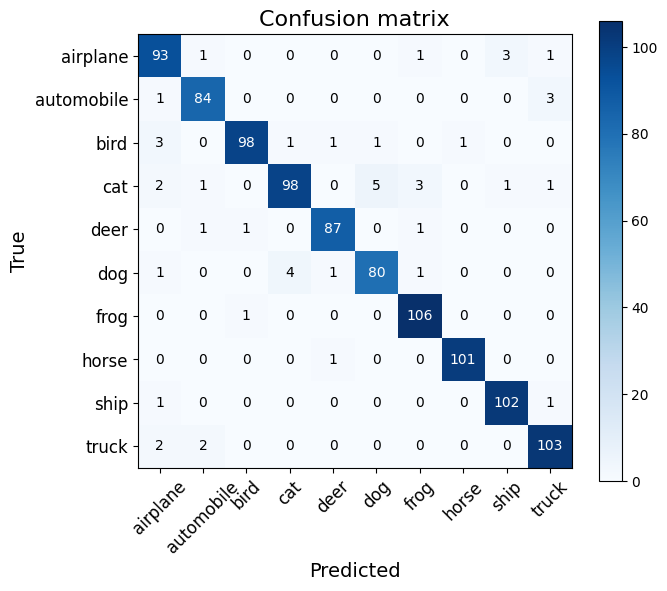

Accuracy: 0.952
Error rate: 0.04800000000000004
Precision micro: 0.952
Precision macro: 0.9518931310807843
Recall micro: 0.952
Recall macro: 0.952059884394532
F1 micro: 0.952
F1 macro: 0.9516817074263862


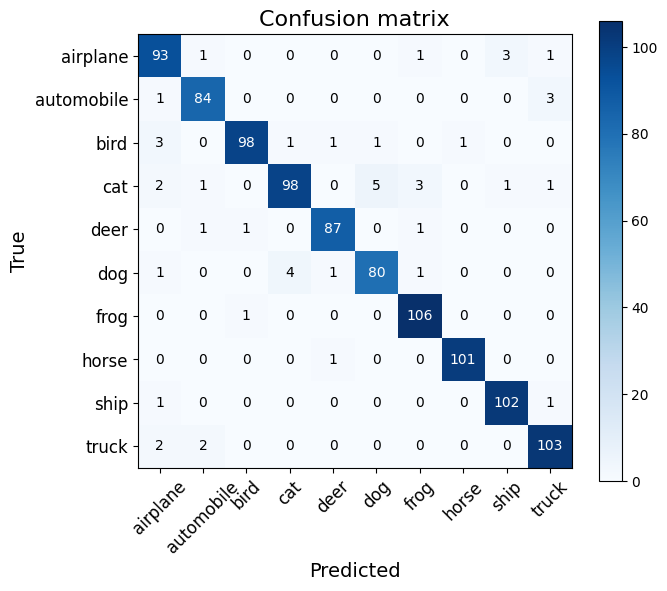

Accuracy: 0.952
Error rate: 0.04800000000000004
Precision micro: 0.952
Precision macro: 0.9518931310807843
Recall micro: 0.952
Recall macro: 0.952059884394532
F1 micro: 0.952
F1 macro: 0.9516817074263862


In [22]:
vis(y_pred, y_true)
vis(y_pred_t, y_true_t)


 Epoch 1 / 10

 Training Loss: 0.424

 Test Loss: 0.393

 Epoch 2 / 10

 Training Loss: 0.331

 Test Loss: 0.326

 Epoch 3 / 10

 Training Loss: 0.276

 Test Loss: 0.283

 Epoch 4 / 10

 Training Loss: 0.238

 Test Loss: 0.254

 Epoch 5 / 10

 Training Loss: 0.212

 Test Loss: 0.234

 Epoch 6 / 10

 Training Loss: 0.192

 Test Loss: 0.218

 Epoch 7 / 10

 Training Loss: 0.178

 Test Loss: 0.206

 Epoch 8 / 10

 Training Loss: 0.165

 Test Loss: 0.197

 Epoch 9 / 10

 Training Loss: 0.156

 Test Loss: 0.189

 Epoch 10 / 10

 Training Loss: 0.146

 Test Loss: 0.183


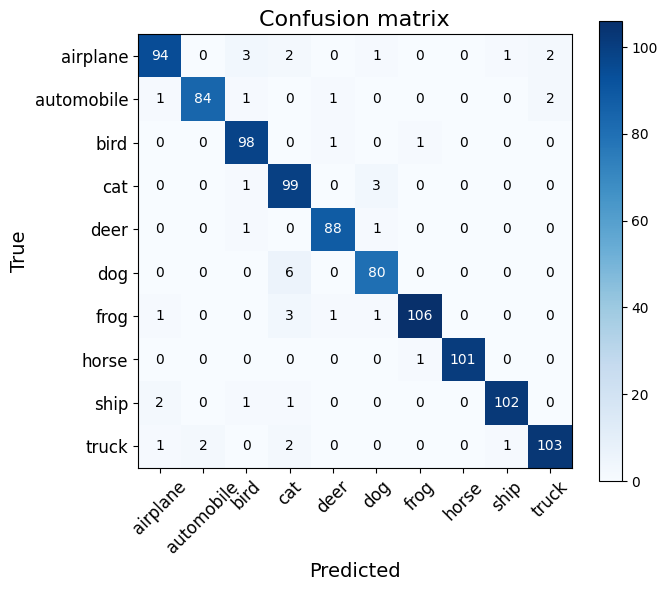

Accuracy: 0.955
Error rate: 0.04500000000000004
Precision micro: 0.955
Precision macro: 0.9557811723418179
Recall micro: 0.955
Recall macro: 0.9549459897647111
F1 micro: 0.955
F1 macro: 0.9549908076090732


In [39]:
epochs = 10
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    val_loss = test()
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f'\n Training Loss: {train_loss:.3f}')
    print(f'\n Test Loss: {val_loss:.3f}')
    
y_pred, y_true = predict()

cm = confusion_matrix(y_true, y_pred)

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(cm, cmap='Blues')
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center',
                 color='white' if cm[i, j] > cm.max() / 2 else 'black',
                 fontsize=10)

plt.tight_layout()
plt.show()

acc = accuracy_score(y_true, y_pred)
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", acc)
print("Error rate:", 1 - acc)
print("Precision micro:", precision_micro)
print("Precision macro:", precision_macro)
print("Recall micro:", recall_micro)
print("Recall macro:", recall_macro)
print("F1 micro:", f1_micro)
print("F1 macro:", f1_macro)

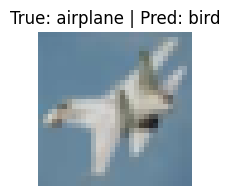

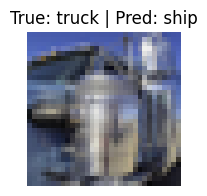

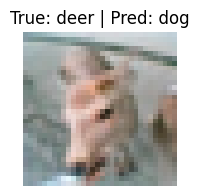

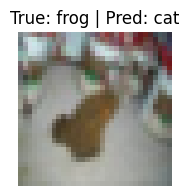

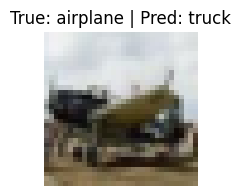

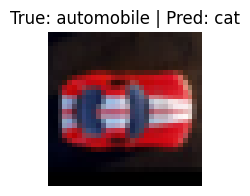

In [28]:
DISPLAY_COUNT = 6

mismatch_idx = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p][:DISPLAY_COUNT]

for idx in mismatch_idx:
    example = test_ds[idx]
    img = example["img"]         
    true_label = cifar10_classes[example["label"]]
    pred_label = cifar10_classes[y_pred[idx]]

    plt.figure(figsize=(2,2))
    plt.imshow(np.array(img))   
    plt.axis("off")
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.show()